In [1]:
import numpy as np
import xarray as xr
import pyproj
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs

import sys
sys.path.append('../')

from plotfunctions import add_lonlat

np.seterr(all='ignore')
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [137]:
startyear,endyear = 1966,1966

axex = [245.8,251,-75.2,-74.4]
proj = ccrs.SouthPolarStereo(true_scale_latitude=-75,central_longitude=0)

In [17]:
#Read MITgcm data for region corresponding to geometry
timep= slice(f"{startyear}-1-1",f"{endyear}-12-31")
ds = xr.open_dataset('../../../data/paulholland/PAS_851/stateTheta.nc')
ds = ds.sel(LONGITUDE=slice(360-114.7,360-109),LATITUDE=slice(-75.3,-74.1),TIME=timep)
ds = ds.mean(dim='TIME')
lon   = (ds.LONGITUDE-360.).values
lat   = (ds.LATITUDE-.05).values
dep   = ds.DEPTH.values
theta = ds.THETA.values
ds.close()
ds = xr.open_dataset('../../../data/paulholland/PAS_851/stateSalt.nc')
ds = ds.sel(LONGITUDE=slice(360-114.7,360-109),LATITUDE=slice(-75.3,-74.1),TIME=timep)
ds = ds.mean(dim='TIME')
salt  = ds.SALT.values
ds.close()

In [173]:
T = np.zeros((len(lat),len(lon)))
S = np.zeros((len(lat),len(lon)))
D = np.zeros((len(lat),len(lon)))
draft = np.zeros((len(lat),len(lon)))
depp = (dep[1:]+dep[:-1])/2
for j,jj in enumerate(lat):
    for i,ii in enumerate(lon):
        if salt[0,j,i] == 0:
            k = np.nonzero(salt[:,j,i])[0]
            if len(k)>0:
                T[j,i] = theta[k[0],j,i]
                S[j,i] = salt[k[0],j,i]
                draft[j,i] = dep[k[0]]
            else:
                T[j,i] = np.nan
                S[j,i] = np.nan
                draft[j,i] = np.nan
        else:
            T[j,i] = np.nan
            S[j,i] = np.nan
            draft[j,i] = np.nan
            
        Sq = np.where(salt[:,j,i]==0,np.nan,salt[:,j,i])
        dSdz = (Sq[1:]-Sq[:-1])/(dep[1:]-dep[:-1])
        if ~np.isnan(S[j,i]) and sum(~np.isnan(dSdz))>2:
            D[j,i] = depp[np.nanargmax(dSdz)]-draft[j,i]
        else:
            D[j,i] = np.nan

In [174]:
def makebackground(ax,axex):
    cmap = plt.get_cmap('ocean')
    ds = xr.open_dataset('../../../data/BedMachineAntarctica_2020-07-15_v02.nc')
    ds = ds.isel(x=slice(3400,3800),y=slice(7700,8150))
    mask = xr.where(ds.mask==1,2,ds.mask)
    ds = add_lonlat(ds)
    
    ax.set_facecolor(".7")
    
    cmap1 = mpl.colors.ListedColormap(plt.get_cmap('cmo.ice')(np.linspace(0,.5,255)))
    cmap3 = mpl.colors.ListedColormap(plt.get_cmap('cmo.gray')(np.linspace(.5,.8,255)))

    im1 = ax.pcolormesh(ds.lon,ds.lat,np.where(mask==0,ds.bed,np.nan),cmap=cmap1,shading='nearest',transform=ccrs.PlateCarree(),vmin=-1500,vmax=0)
    im2 = ax.pcolormesh(ds.lon,ds.lat,np.where(mask==2,ds.surface-ds.thickness,np.nan),cmap=cmap3,shading='nearest',transform=ccrs.PlateCarree(),vmin=0,vmax=2000)

    ax.set_extent(axex,crs=ccrs.PlateCarree())

In [187]:
def plotmelt(nax,lon,lat,var,cmap,vmin,vmax,title=''):
    ax = fig.add_subplot(3,4,nax,projection=proj)
    makebackground(ax,axex)
    ax.set_extent(axex,crs=ccrs.PlateCarree())
    im = ax.pcolormesh(lon,lat,var,cmap=cmap,vmin=vmin,vmax=vmax,shading='nearest',transform=ccrs.PlateCarree())
    ax.set_title(title,loc='left')
    return im

In [207]:
def addcbar(nax,im,label,extend='both'):
    ax = fig.add_subplot(3,4,nax)
    ax.set_visible(False)
    axins = inset_axes(ax,width="8%",height="100%",loc='lower left',bbox_to_anchor=(1.03, 0, 1, 1),bbox_transform=ax.transAxes,borderpad=0)
    cbar = plt.colorbar(im, cax=axins,extend=extend)
    cbar.set_label(label)

In [208]:
Tmin = -2
Tmax = .5
Smin = 33.6
Smax = 34.6
Dmin = 0
Dmax = 200

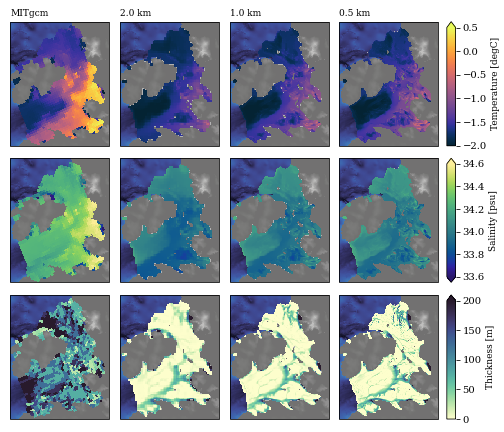

In [210]:
plt.style.use('style_paper')

mpl.rc('figure.subplot',left=.01,right=.88,top=.95,bottom=.03,wspace=0,hspace=.1)

fig = plt.figure(figsize=(7,6))

#MITgcm
imT = plotmelt(1,lon,lat,T,'cmo.thermal',Tmin,Tmax,'MITgcm')
imS = plotmelt(5,lon,lat,S,'cmo.haline',Smin,Smax)
imD = plotmelt(9,lon,lat,D,'cmo.deep',Dmin,Dmax)

#Layer
for r,res in enumerate(['2.0','1.0','0.5']):
    ds = xr.open_dataset(f'../../results/spinup/CrossDots_{res}_mitgcm_{startyear}_{endyear}_030.nc')
    plotmelt(2+r,ds.lon,ds.lat,np.where(ds.tmask,ds.T,np.nan),'cmo.thermal',Tmin,Tmax,f'{res} km')
    plotmelt(6+r,ds.lon,ds.lat,np.where(ds.tmask,ds.S,np.nan),'cmo.haline',Smin,Smax)
    plotmelt(10+r,ds.lon,ds.lat,np.where(ds.tmask,ds.D,np.nan),'cmo.deep',Dmin,Dmax)
    ds.close()

addcbar(4,imT,'Temperature [degC]','max')
addcbar(8,imS,'Salinity [psu]')
addcbar(12,imD,'Thickness [m]','max')

plt.savefig('../../figures/draftplot_validation.png',dpi=450)